In [1]:
from torch import nn
import torch
import os
import pandas as pd
from tqdm import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import random
import torch.multiprocessing as mp


mp.set_start_method('spawn', force=True)

### CONFIG
pre_processing = False


In [2]:
### CLEANING UP THE ODIR DATASET BY REMOVING RETINAL FUNDUS IMAGES FEATURING DISEASES
import os
import pandas as pd
import tqdm

damaged_images = []

if pre_processing:
    print("Scanning through the labels file...")
    labels = pd.read_excel("ODIR/labels.xlsx")
    for i in tqdm.tqdm(range(len(labels["ID"]))):
        if "normal fundus" not in labels["Left-Diagnostic Keywords"][i]:
            damaged_images.append(labels["Left-Fundus"][i])
        if "normal fundus" not in labels["Right-Diagnostic Keywords"][i]:
            damaged_images.append(labels["Right-Fundus"][i])
    
    print(f"\nLength of the corrected dataset: {len(labels['ID']+1)*2 - len(damaged_images)}")
    
    print(f"\nDeleting the corrupted images...")
    dir = os.listdir("ODIR/images")
    i = 0
    for file in tqdm.tqdm(dir):
        if file in damaged_images:
            os.remove(f"ODIR/images/{file}")


In [3]:
### HIDDEN FILES
import shutil

dirlist = ["ODIR/images", "ODIR/newimages", "COMPOSITE/BRSET/files/BRSET2/1/images", "COMPOSITE/BRSET/files/BRSET2/1/newimages", "COMPOSITE/", "COMPOSITE/dataset", "COMPOSITE/dataset/*/", "COMPOSITE/dataset/*/*/"]
for directory in dirlist: 
    try:
        files = os.listdir(directory)
    except FileNotFoundError:
        os.makedirs(directory)
    for file in files:
        path = os.path.join(directory, file)
        if file.startswith('.'):
            if os.path.isdir(path):
                shutil.rmtree(path)  # Removes directories and their contents
                print(f"Directory {file} removed from directory.")
            else:
                os.remove(path)  # Removes files
                print(f"File {file} removed from directory.")

Directory .ipynb_checkpoints removed from directory.


In [4]:
## RENAMING FILES TO FEATURE LABEL
odirdir =  "ODIR/images/"
brsetdir = "COMPOSITE/BRSET/files/BRSET2/1/images"

#ODIR
if pre_processing:
    labels = pd.read_excel('ODIR/labels.xlsx')
    for file in tqdm(os.listdir(odirdir)):
       if "male" not in file and "female" not in file:
            matched_rows = labels[(labels["Left-Fundus"] == file) | (labels["Right-Fundus"] == file)]
            if not matched_rows.empty:
                for index, row in matched_rows.iterrows():
                    sex = row["Patient Sex"]
                    os.rename(os.path.join(brsetdir, file), os.path.join(brsetdir, f'{sex}_{file}'))

#BRSET
if pre_processing:
    labels = pd.read_csv('COMPOSITE/BRSET/files/BRSET2/1/labels.csv')
    for file in tqdm(os.listdir(brsetdir)):
        if "male" not in file and "female" not in file:
            matched_rows = labels[(labels["image_id"] + '.jpg' == file)]
            if not matched_rows.empty:
                for index, row in matched_rows.iterrows():
                    if row["patient_sex"] == 1:
                        sex = "Male"
                    elif row["patient_sex"] == 2:
                        sex = "Female"
                    os.rename(os.path.join(brsetdir, file), os.path.join(brsetdir, f'{sex}_{file}'))
            if matched_rows.empty:
                print(f"No match for file: {file}")

In [5]:
### CROPPING FILES TO CENTER AROUND THE RETINA
# Warning: when running this box, current directory must be the the Neuro140FP dir.
BRSET_preprocessing = False

#BASE FUNCTION
if pre_processing:
    def preprocess_image_color(image_path, output_size=(300, 300)):
        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"The specified image was not found or could not be read: {image_path}")
        
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        lower_bound = np.array([0, 0, 50])  # low saturation, medium value
        upper_bound = np.array([180, 255, 255])  # Full hue range, high saturation, high value
    
        mask = cv2.inRange(hsv_image, lower_bound, upper_bound)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour)
            cropped_image = image[y:y+h, x:x+w]
            resized_image = cv2.resize(cropped_image, output_size, interpolation=cv2.INTER_AREA)
            return resized_image
        else:
            return cv2.resize(image, output_size, interpolation=cv2.INTER_AREA)

#ODIR
    if len(os.listdir("ODIR/newimages")) != len(os.listdir("ODIR/images")):
        files = os.listdir("ODIR/images")
        for file in tqdm(files):
            processed_image = preprocess_image_color(f"ODIR/images/{file}")
            if not os.path.exists('ODIR/newimages/'):
                os.makedirs('ODIR/newimages/')
            cv2.imwrite(f'ODIR/newimages/{file}', processed_image)

#BRSET
    if BRSET_preprocessing:
        if len(os.listdir("COMPOSITE/BRSET/files/BRSET2/1/images")) != len(os.listdir("COMPOSITE/BRSET/files/BRSET2/1/newimages")):
            files = os.listdir("COMPOSITE/BRSET/files/BRSET2/1/images")
            for file in tqdm(files):
                processed_image = preprocess_image_color(f"COMPOSITE/BRSET/files/BRSET2/1/images/{file}")
                if not os.path.exists('COMPOSITE/BRSET/files/BRSET2/1/newimages/'):
                    os.makedirs('COMPOSITE/BRSET/files/BRSET2/1/newimages')
                cv2.imwrite(f'COMPOSITE/BRSET/files/BRSET2/1/newimages/{file}', processed_image)
    else:
        skipped_files = 0
        for filename in tqdm(os.listdir("COMPOSITE/BRSET/files/BRSET2/1/images")):
            source_file = os.path.join("COMPOSITE/BRSET/files/BRSET2/1/images", filename)
        
            # Check if the file is not a directory
            if os.path.isfile(source_file):
                destination_file = os.path.join("COMPOSITE/BRSET/files/BRSET2/1/newimages", filename)
        
                # Check if the file already exists in the destination directory
                if not os.path.exists(destination_file):
                    # Copy the file to the destination directory
                    shutil.copy2(source_file, destination_file)
                else:
                    skipped_files += 1
        print(f"Amount of skipped files: {skipped_files}")


In [6]:
## CREATING TRAIN AND VAL DIRECTORIES, WITH SEPARATE FOLDER FOR CLASSES
if pre_processing:
    source_dir = 'COMPOSITE/dataset'
    train_dir = os.path.join(source_dir, 'train')
    val_dir = os.path.join(source_dir, 'val')
    train_male_dir = os.path.join(train_dir, 'male')
    train_female_dir = os.path.join(train_dir, 'female')
    val_male_dir = os.path.join(val_dir, 'male')
    val_female_dir = os.path.join(val_dir, 'female')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(train_male_dir, exist_ok=True)
    os.makedirs(train_female_dir, exist_ok=True)
    os.makedirs(val_male_dir, exist_ok=True)
    os.makedirs(val_female_dir, exist_ok=True)

In [7]:
## MOVING FILES INTO A COMMON DIR
def move_files(src_dir, dest_dir):
        os.makedirs(dest_dir, exist_ok=True)

        files = [f for f in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, f))]
    
        for f in tqdm(files):
            src_path = os.path.join(src_dir, f)
            dest_path = os.path.join(dest_dir, f)
            if not os.path.exists(dest_path):
                try:
                    shutil.move(src_path, dest_path)
                except Exception as e:
                    print(f"Failed to move {src_path} to {dest_path}: {e}")
            else:
                print(f"File {f} already exists in {dest_dir}, skipping.")
            
if pre_processing:
    img_dir = os.path.join('COMPOSITE', 'ALLIMAGES')
    brset_dir = os.path.join('COMPOSITE', 'BRSET', 'files', 'BRSET2', '1', 'newimages')
    odir_dir = os.path.join('ODIR', 'newimages')
    
    move_files(brset_dir, img_dir)
    move_files(odir_dir, img_dir)



In [8]:
## MOVING INTO TRAIN AND VAL DIRECTORIES
from sklearn.model_selection import train_test_split

def move_files_wlabels(files, dest):
    for f in tqdm(files):
        if f not in dest:
            sex = f.split('_')[0]
            label_dir = os.path.join(dest, sex)
            os.makedirs(label_dir, exist_ok=True)
            shutil.move(os.path.join(img_dir, f), os.path.join(label_dir, f))
            
if pre_processing:
    files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
    train_files, val_files = train_test_split(files, test_size=0.2, random_state=42)
    move_files_wlabels(train_files, train_dir)
    move_files_wlabels(val_files, val_dir)

In [9]:
## DEBUG: Checking the length of all the files used
train_female_len = len(os.listdir("COMPOSITE/dataset/train/Female"))
train_male_len = len(os.listdir("COMPOSITE/dataset/train/Male"))
val_female_len = len(os.listdir("COMPOSITE/dataset/val/Female"))
val_male_len = len(os.listdir("COMPOSITE/dataset/val/Male"))

print(f"Total no. of images: {train_female_len + train_male_len + val_female_len + val_male_len}")
print(f"Percentage of all images in training set: {(train_female_len + train_male_len) / (train_female_len + train_male_len + val_female_len + val_male_len)}")
print(f"Percentage of males in training set: {train_male_len / (train_male_len + train_female_len)}")
print(f"Percentage of males in validation set: {val_male_len / (val_male_len + val_female_len)}")

Total no. of images: 19364
Percentage of all images in training set: 0.7999896715554637
Percentage of males in training set: 0.4083015944742108
Percentage of males in validation set: 0.41027627162406405


In [10]:
## IMPORTING THE DATASET CLASS
from composite_dataset import ODIRDataset

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
### TRANSFORMS
import torch
from torchvision.transforms import v2

train_transforms = v2.Compose([
    v2.Resize(size=(300, 300)),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(10),
    v2.ToTensor()
    #v2.Normalize(mean=[0.3004, 0.1870, 0.1007], std=[0.2777, 0.1806, 0.1034])
    #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = v2.Compose([
    v2.Resize(size=(300, 300)),
    v2.ToTensor()
])

/opt/conda/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [12]:
### LOADING DATA

from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = 0

dsets = {
    'train': ODIRDataset(targ_dir="COMPOSITE/dataset/train",
                         transform=train_transforms),
    'val': ODIRDataset(targ_dir="COMPOSITE/dataset/val",
                       transform=val_transforms)
}

dset_loaders = {
    'train': DataLoader(dsets['train'], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=True),
    'val': DataLoader(dsets['val'], batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, drop_last=True)
}

dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}

Target directory: /home/u_481835/Neuro140FP/COMPOSITE/dataset/train
Target directory: /home/u_481835/Neuro140FP/COMPOSITE/dataset/val


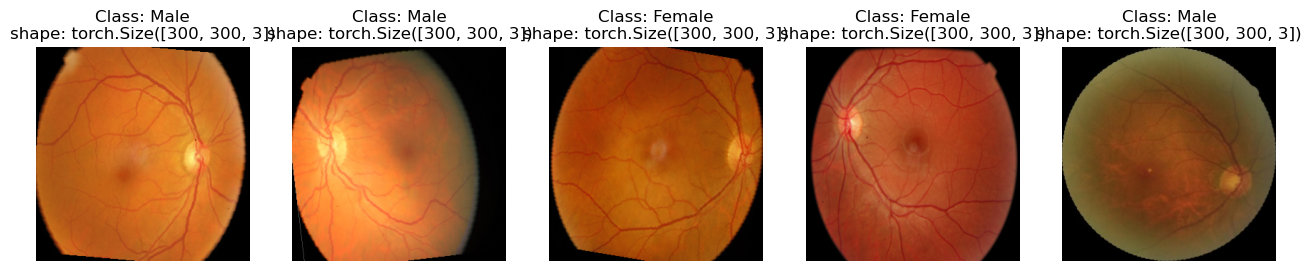

In [13]:
### VISUALIZING DATA

#1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  #2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print("For display purposes, n shouldn't be larger than 10, setting it to 10 and removing shape display")

  #3. Set the seed
  if seed:
    random.seed(seed)

  #4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  #5. Setup plot
  plt.figure(figsize=(16, 8))

  #6. Loop through and plot random indexes
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    #7. Adjust tensor dimensions
    targ_image_adjust = targ_image.permute(1, 2, 0)

    #8. Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis(False)
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)

display_random_images(dsets['train'],
                      n=5,
                      classes=dsets['train'].classes,
                      seed=None)

In [14]:
### DEBUG: Get image and label from custom dataloader
img_custom, label_custom = next(iter(dset_loaders['train']))
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 300, 300]), torch.Size([32]))

In [15]:
### AGNOSTIC CODE
device = "cuda" if torch.cuda.is_available() else "cpu"

In [16]:
### IMPORTING AND MODIFYING RESNET50
from torchvision import models
from torchvision.models import ResNet50_Weights, resnet50
model1 = models.resnet50(weights=ResNet50_Weights.DEFAULT)

for param in model1.parameters():
    param.requires_grad = False
for param in model1.fc.parameters():
    param.requires_grad = True

nr_filters = model1.fc.in_features
model1.fc = nn.Linear(nr_filters, 1)

model1 = model1.to(device)

In [17]:
model1.load_state_dict(torch.load('retfunweights2.pt'))

<All keys matched successfully>

In [18]:
### MODEL VISUALIZATION
from torchinfo import summary
summary(model1, input_size=[32, 3, 300, 300])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 1]                   --
├─Conv2d: 1-1                            [32, 64, 150, 150]        (9,408)
├─BatchNorm2d: 1-2                       [32, 64, 150, 150]        (128)
├─ReLU: 1-3                              [32, 64, 150, 150]        --
├─MaxPool2d: 1-4                         [32, 64, 75, 75]          --
├─Sequential: 1-5                        [32, 256, 75, 75]         --
│    └─Bottleneck: 2-1                   [32, 256, 75, 75]         --
│    │    └─Conv2d: 3-1                  [32, 64, 75, 75]          (4,096)
│    │    └─BatchNorm2d: 3-2             [32, 64, 75, 75]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 75, 75]          --
│    │    └─Conv2d: 3-4                  [32, 64, 75, 75]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 75, 75]          (128)
│    │    └─ReLU: 3-6                    [32, 64, 75, 75]   

In [19]:
### FUNCTION FOR MODEL TRAINING
import time
import copy
NUM_EPOCHS = 0

def train_model(model, loss_fn, optimizer, lr_scheduler, num_epochs=NUM_EPOCHS):
    
    since = time.time()
    best_model = model
    best_acc = 0.0

    accuracies = {'train': [], 'val': []}
    losses = {'train': [], 'val': []}

    for epoch in range(num_epochs):
        print('-' * 10)
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch)
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            counter = 0

            for data in dset_loaders[phase]:
                inputs, labels = data

                if device == 'cuda':
                    try:
                        inputs = inputs.to(device).float()
                        labels = labels.to(device).float()
                    except Exception as e:
                        print("ERROR! Here are the inputs and labales before full stack trace.")
                        raise e
                
                optimizer.zero_grad()
                outputs = model(inputs)
                if outputs.dim() > 1 and outputs.shape[1] == 1:
                    outputs = outputs.squeeze(1)
                preds = torch.round(torch.sigmoid(outputs))
                
                if torch.isnan(outputs).any() or torch.isnan(labels).any():
                    print("NaNs detected in outputs or labels")
                if torch.isinf(outputs).any() or torch.isinf(labels).any():
                    print("Infs detected in outputs or labels")
                    
                loss = loss_fn(outputs, labels)
                #print("Outputs:", outputs)
                #print("Loss:", loss)
                #print("Loss item:", loss.item())
                
                if counter%10==0:
                    print('Reached batch iteration', counter)
                counter+=1

                if phase == 'train':
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()
                try:
                    running_loss += loss.item()
                    running_corrects += torch.sum(preds == labels.data)
                except:
                    print('Unexpected error, could not calculate loss or sum.')
                
            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects.item() / float(dset_sizes[phase])
            print(f'{phase} loss: {epoch_loss:.4f} and acc: {epoch_acc:.4f}')
            accuracies[phase].append(epoch_acc)
            losses[phase].append(epoch_loss)

            if phase == 'val':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model = copy.deepcopy(model)
                    print('New best accuracy =', best_acc)

        if device == 'cuda':
            torch.cuda.empty_cache()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('returning and looping back')

    # Returns the best model and the statistical dictionaries
    return best_model, accuracies, losses

In [20]:
### LOSS FUNCTION, OPTIMIZER AND LR SCHEDULER SETUP
BASE_LR = 0.1
EPOCH_DECAY = 2
DECAY_WEIGHT = 0.1

def exp_lr_scheduler(optimizer, epoch, init_lr=BASE_LR, lr_decay_epoch=EPOCH_DECAY):
    lr = init_lr * (DECAY_WEIGHT**(epoch//lr_decay_epoch))
    if epoch % lr_decay_epoch == 0:
        print(f'LR is now set to {lr}')
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model1.parameters(),
                            lr=BASE_LR,
                            weight_decay=1e-5)
if device == 'cuda':
    loss_fn.to(device)

In [23]:
### RUNNING THE MODEL
NUM_EPOCHS = 1

torch.save(model1.state_dict, 'COMPOSITE/initial_tuned_best_model.pt')
model1, accuracies, losses = train_model(model1, loss_fn, optimizer, exp_lr_scheduler, num_epochs=NUM_EPOCHS)

for split in ['train', 'val']:
    print(split, "accuracies by epoch:", accuracies[split])
    print(split, "accuracies by epoch:", losses[split])

torch.save(model1.state_dict, 'retfunweights5.pt')

----------
Epoch 0/0
----------
LR is now set to 0.1
Reached batch iteration 0
Reached batch iteration 10
Reached batch iteration 20
Reached batch iteration 30
Reached batch iteration 40
Reached batch iteration 50
Reached batch iteration 60
Reached batch iteration 70
Reached batch iteration 80
Reached batch iteration 90
Reached batch iteration 100
Reached batch iteration 110
Reached batch iteration 120
Reached batch iteration 130
Reached batch iteration 140
Reached batch iteration 150
Reached batch iteration 160
Reached batch iteration 170
Reached batch iteration 180
Reached batch iteration 190
Reached batch iteration 200
Reached batch iteration 210
Reached batch iteration 220
Reached batch iteration 230
Reached batch iteration 240
Reached batch iteration 250
Reached batch iteration 260
Reached batch iteration 270
Reached batch iteration 280
Reached batch iteration 290
Reached batch iteration 300
Reached batch iteration 310
Reached batch iteration 320
Reached batch iteration 330
Reache

In [24]:
torch.save(model1.state_dict(), 'retfunweights5.pt')